# Equilibrium experiments with OGGM

Code used to create the graphics used in this blog post: https://oggm.org/2021/08/10/equilibrium-runs-oggm

You can use the various parameter settings below:

In [1]:
# Period

y0 = 2009
hs = 10
str1, str2 = ('2000', '2020')

#y0 = 1970
#hs = 10
#str1, str2 = ('1960', '1980')

In [2]:
# Libs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Locals
import oggm.cfg as cfg
from oggm import tasks, utils, workflow
from oggm.core import massbalance

In [3]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_spinup_run')
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = False

/home/lilianschuster/oggm/oggm/cfg.py:381: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2021-08-15 12:41:26: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-08-15 12:41:26: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-08-15 12:41:26: oggm.cfg: Multiprocessing: using all available processors (N=8)


Pre-processed directories are being used here.

In [4]:
# How many grid points around the glacier?
# Make it large if you expect your glaciers to grow large
cfg.PARAMS['border'] = 80

# Go - initialize glacier directories

gdir = workflow.init_glacier_regions(['RGI60-11.01450'], from_prepro_level=3)[0]

# Today's glacier geometry
h, w = gdir.get_inversion_flowline_hw()

2021-08-15 12:41:29: oggm.cfg: PARAMS['border'] changed from `40` to `80`.
2021-08-15 12:41:29: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2021-08-15 12:41:29: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


In [5]:
years = np.arange(y0-hs, y0+hs+1)
months = np.arange(1, 13)

In [6]:
mb_past = massbalance.PastMassBalance(gdir)

df_past = pd.DataFrame(index=months)
for y in years:
    mb = []
    for m in months:
        tmp = mb_past.get_monthly_mb(h, utils.date_to_floatyear(y, m)) * cfg.SEC_IN_MONTH * cfg.PARAMS['ice_density']
        mb.append(np.average(tmp, weights=w))
    df_past[y] = mb

In [28]:
mb_const = massbalance.ConstantMassBalance(gdir, y0=y0, halfsize=hs)

df_const = pd.DataFrame(index=months)
mb = []
for m in months:
    tmp = mb_const.get_monthly_mb(h, utils.date_to_floatyear(y, m)) * cfg.SEC_IN_MONTH * cfg.PARAMS['ice_density']
    mb.append(np.average(tmp, weights=w))
df_const['AvgMb'] = mb

In [29]:
mb_avg = massbalance.AvgClimateMassBalance(gdir, y0=y0, halfsize=hs)
mb = []
for m in months:
    tmp = mb_avg.get_monthly_mb(h, utils.date_to_floatyear(y, m)) * cfg.SEC_IN_MONTH * cfg.PARAMS['ice_density']
    mb.append(np.average(tmp, weights=w))
df_const['AvgClim'] = mb

In [30]:
df_past.index = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
df_const.index = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]

df_past = df_past.sort_index()
df_const = df_const.sort_index()

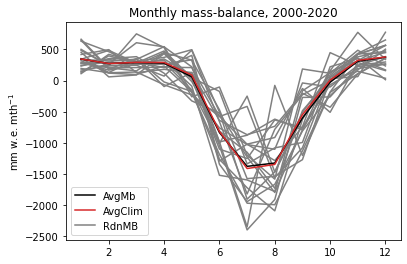

In [31]:
df_past = df_past.sort_index()
ax = df_past.plot(legend=False, c='grey');
df_const['RdnMB'] = np.NaN
df_const.plot(color=['k', 'C3', 'grey'], ax=ax);
plt.title(f'Monthly mass-balance, {str1}-{str2}'); plt.ylabel('mm w.e. mth$^{-1}$');
#plt.savefig(f'/home/mowglie/Documents/git/oggm.github.io/img/blog/equilibrium/monthly_mb_{str2}.png', dpi=150, bbox_inches='tight')

In [33]:
df_past.mean(axis=1).sum()

-2218.4298782163432

In [34]:
df_const.sum()

AvgMb     -2218.512681
AvgClim   -2109.381874
RdnMB         0.000000
dtype: float64

In [35]:
tasks.run_random_climate(gdir, nyears=300, y0=y0, halfsize=hs, output_filesuffix='_rdn', unique_samples=True, seed=0)
ds_rdn = utils.compile_run_output([gdir], input_filesuffix='_rdn')

2021-08-11 15:57:02: oggm.core.flowline: (RGI60-11.01450) run_random_climate_rdn
2021-08-11 15:57:03: oggm.core.flowline: (RGI60-11.01450) flowline_model_run_rdn
2021-08-11 15:57:56: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-08-11 15:57:56: oggm.utils: Applying compile_run_output on 1 gdirs.


In [36]:
tasks.run_constant_climate(gdir, nyears=300, y0=y0, halfsize=hs, output_filesuffix='_const')
ds_const = utils.compile_run_output([gdir], input_filesuffix='_const')

2021-08-11 15:57:56: oggm.core.flowline: (RGI60-11.01450) run_constant_climate_const
2021-08-11 15:57:56: oggm.core.flowline: (RGI60-11.01450) flowline_model_run_const
2021-08-11 15:58:50: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-08-11 15:58:50: oggm.utils: Applying compile_run_output on 1 gdirs.


In [37]:
tasks.run_constant_climate(gdir, nyears=300, y0=y0, halfsize=hs, use_avg_climate=True, output_filesuffix='_avg')
ds_avg = utils.compile_run_output([gdir], input_filesuffix='_avg')

2021-08-11 15:58:50: oggm.core.flowline: (RGI60-11.01450) run_constant_climate_avg
2021-08-11 15:58:50: oggm.core.flowline: (RGI60-11.01450) flowline_model_run_avg
2021-08-11 15:58:50: oggm.core.flowline: TypeError occurred during task flowline_model_run_avg on RGI60-11.01450: __init__() got an unexpected keyword argument 'use_avg_climate'
2021-08-11 15:58:50: oggm.core.flowline: TypeError occurred during task run_constant_climate_avg on RGI60-11.01450: __init__() got an unexpected keyword argument 'use_avg_climate'


TypeError: __init__() got an unexpected keyword argument 'use_avg_climate'

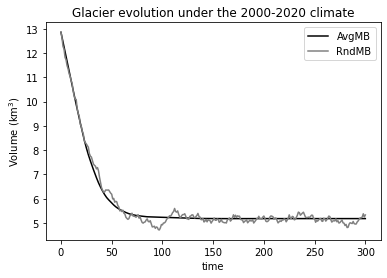

In [38]:
(ds_const.volume * 1e-9).plot(c='k', label='AvgMB');
#(ds_avg.volume * 1e-9).plot(c='C3', label='AvgClim');
(ds_rdn.volume * 1e-9).plot(c='grey', label='RndMB');
plt.legend();
plt.title(f'Glacier evolution under the {str1}-{str2} climate'); plt.ylabel('Volume (km$^3$)');
#plt.savefig(f'/home/mowglie/Documents/git/oggm.github.io/img/blog/equilibrium/volume_{str2}.png', dpi=150, bbox_inches='tight')

In [ ]:
ls 

In [24]:
gdir.get_ref_mb_data(input_filesuffix=

InvalidWorkflowError: Please process some climate data before call